### Batches, Batch Normalization and Dropout

In this workbook you can experiment what you learnt about how to make batches out of your data, how to perform batch normalization and dropout

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim


Load the data from data/batches_norm_drop.csv, then take a look at them.

In [4]:
# YOUR CODE HERE
data = pd.read_csv('data/batches_norm_drop.csv', header=None)
data.head()

,0,1,2
0,0.350140,4.248592,0
1,0.950728,3.528855,0
2,1.371517,3.149416,0
3,0.268221,4.337209,0
4,1.881996,1.515387,0


In [135]:
data[2].value_counts()

0    250
1    250
2    250
Name: 2, dtype: int64

Now you are ready to code your own function to create batches. If needed rewatch the video we provided in Eduflow.

**Extra challange:**    Are you able to split between train and test _**without**_ using sklearn?

In [5]:
def train_test_split(data, testsize = 0.2):
    data  = data.copy()
    idx = list(data.index)
    np.random.shuffle(idx) # inplace transformation
    test_idx = idx[:int(len(idx) * testsize)]
    train_idx = idx[int(len(idx) * testsize):]
    
    return data.iloc[train_idx], data.iloc[test_idx]




train_set, test_set = train_test_split(data)
train_set.shape, test_set.shape

((600, 3), (150, 3))

In [6]:
x_train, y_train = train_set.drop(2, axis=1), train_set[2]

x_test, y_test = test_set.drop(2, axis=1), test_set[2]

In [141]:
def batchify(x, y, batch_size):
    x, y = x.values, y.values

    n_batches = x.shape[0] // batch_size
    idx = np.random.permutation(x.shape[0])
    x, y = x[idx], y[idx]
    x = x[: batch_size*n_batches].reshape(n_batches, batch_size, x.shape[1])
    y = y[: batch_size*n_batches].reshape(n_batches, batch_size)

    return torch.from_numpy(x).type(torch.float), torch.from_numpy(y).type(torch.long)




x_train_batches, y_train_batches = batchify(x_train, y_train, 16)
x_test_batches, y_test_batches = batchify(x_test, y_test, 16)


x_train_batches.shape, x_test_batches.shape

(torch.Size([37, 16, 2]), torch.Size([9, 16, 2]))

It's time to create your model! Remember to include the new tricks you learnt (batch normalization and dropout)!

In [144]:
input_size = x_train.shape[1]
hiddensizes = [400, 200, 100]
output_size = 3
percent_drop = 0.20
neuralnet = nn.Sequential(
                            nn.Linear(input_size, hiddensizes[0]),
                            nn.Dropout(percent_drop), 
                            nn.BatchNorm1d(hiddensizes[0]), 
                            nn.ReLU(),

                            nn.Linear(hiddensizes[0], hiddensizes[1]), 
                            nn.Dropout(percent_drop), 
                            nn.BatchNorm1d(hiddensizes[1]), 
                            nn.ReLU(),

                            nn.Linear(hiddensizes[1], hiddensizes[2]), 
                            nn.Dropout(percent_drop), 
                            nn.BatchNorm1d(hiddensizes[2]), 
                            nn.ReLU(), 
                            
                            nn.Linear(hiddensizes[2], output_size)
                        )




Train your model and evaluate it. **Extra challenge**: try to figure out how you can tell if batch norm and dropout are effective

100%|██████████| 100/100 [00:23<00:00,  4.19it/s]


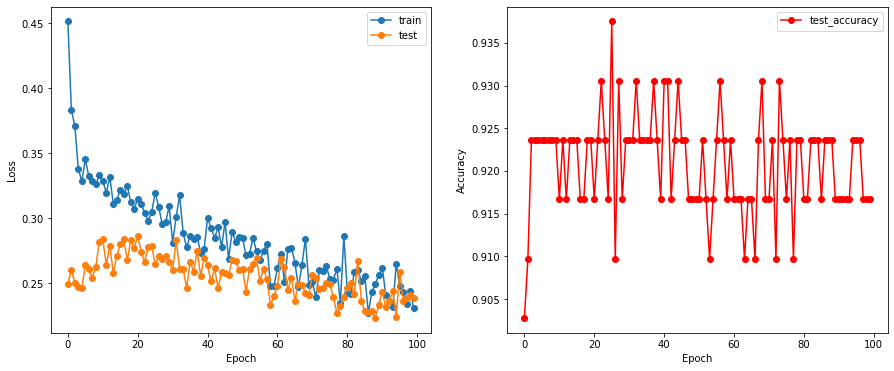

In [145]:
learning_rate = 0.01
epochs = 100
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(neuralnet.parameters(), lr=learning_rate)

train_losses = []
test_losses = []
accuracies = []
for epoch in tqdm(range(epochs)):

    running_loss = 0
    # training
    for x_train_batch, y_train_batch in zip(x_train_batches, y_train_batches):

        optimizer.zero_grad()
        # forward pass
        logits = neuralnet(x_train_batch)

        # loss
        train_loss = criterion(logits, y_train_batch)
        running_loss += train_loss.item()

        # backward pass
        train_loss.backward()

        optimizer.step()

        
    # mean loss (all batches losses divided by the total number of batches)
    train_losses.append(running_loss/x_train_batches.shape[0])


    #validation
    neuralnet.eval()
    with torch.no_grad():
        running_accuracy = 0
        running_loss = 0
        
        for x_test_batch, y_test_batch in zip(x_test_batches, y_test_batches):

            # logits
            test_logits = neuralnet(x_test_batch)

            # predictions
            test_preds = torch.argmax(test_logits, dim=1)

            
            # running accuracy
            running_accuracy += accuracy_score(y_test_batch, test_preds)

            # loss
            test_loss = criterion(test_logits, y_test_batch)
            running_loss += test_loss.item()

        # mean accuracy for each epoch
        accuracies.append(running_accuracy/x_test_batches.shape[0])

        # mean loss for each epoch
        test_losses.append(running_loss/x_test_batches.shape[0])

    neuralnet.train()


# Plots
x_epochs = list(range(epochs))
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(x_epochs, train_losses, marker='o', label='train')
plt.plot(x_epochs, test_losses, marker='o', label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_epochs, accuracies, marker='o',
         c='red', label='test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
    